<a href="https://colab.research.google.com/github/OD1992/Python-programs/blob/main/Exponential_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-39578117827c>:111: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces


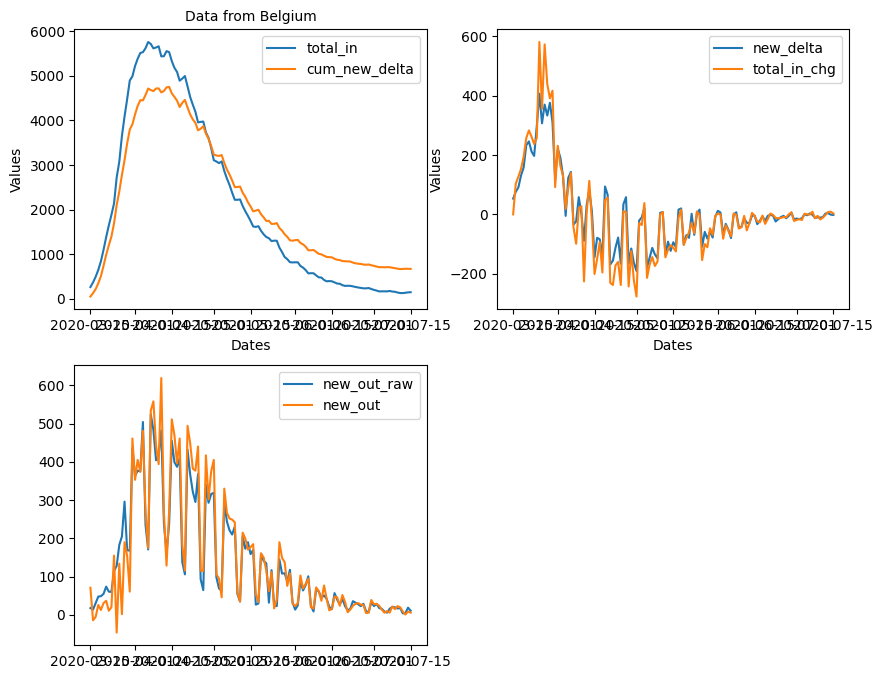

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from scipy.integrate import odeint
import math 
#from mpl_toolkits.mplot3d import Axes3D
#from math import hypot
from scipy import optimize
import copy
from datetime import datetime   # useful for date ranges in plots
#To change repertory
#import os
#os.chdir ('C:\\Users\\odiao\\Desktop\\Model Covid19\\programme_python\\SHR_PA\Code_Python')
#os.getcwd ()
url_belgium = '/COVID19BE_HOSP_2020-07-16.csv'
url_french = '/donnees-hospitalieres-covid19-2020-07-17-19h00_corrected_tmp.csv'
url_lux = '/data_lux.csv'
url_uk = '/data_UK.csv'
# ***********************************************************************************
# Switches and other user choices - see also sw_periods and c_H, c_E, c_L below
# *******
sw_dataset = 'BEL'  # !! Default: 'BEL'. Currently 'BEL' and 'FRA' 'LUX'and 'UK'are available.
sw_districts = 'sum'  # !! Default: 'sum'. If 'sum', sums over all districts (i.e., provinces, departments...). If 'each', loop over all districts. sw_districts can also be the name of a district (for example, sw_districts = 'Brussels', or sw_districts = '75' for Paris).

show_totinout = 1  # Default: 0 # If 1, shows plots of total, in and out and check their discrepancy.
save_figures = 0  # If 1, some figures will be saved in pdf format.

show_figures = 1  # If 0, no figure shown. Will be set to 0 later on if nb_districts too large.
show_hist = 0
show_H = 1  # If 1, draw a plot of the evolution of H(t).
show_S_bar = 1
show_beta_bar = 1
show_gamma = 1
#Be carreful about changing the max of ylim.
# ***********************************************************************************
# Load data Belgium
# *******
if sw_dataset == 'BEL':   
    # The data comes from https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv.
    # This link was provided on 22 June 2020 by Alexey Medvedev on the "Re R0 estimation" channel of the O365G-covidata team on MS-Teams.
    # The link can be reached from https://epistat.wiv-isp.be/covid/
    # Some explanations can be found at https://epistat.sciensano.be/COVID19BE_codebook.pdf

    data_raw = pd.read_csv(url_belgium)
    #fields = ['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']

    if sw_districts == 'each':
        data_groupbydistrict = pd.DataFrame(data_raw.groupby("PROVINCE"))
# ***********************************************************************************
# Load data France
# *******

if sw_dataset == 'FRA':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv(url_french)  # some dates were not in the correct format, hence the "corrected" version of the csv file
    data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.

    if sw_districts == 'each':
        data_groupbydistrict = pd.DataFrame(data_raw.groupby("dep"))
# ***********************************************************************************
# Load data Luxembourg
# *******
if sw_dataset == 'LUX':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv(url_lux)  # some dates were not in the correct format, hence the "corrected" version of the csv file
    #data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.
    data_groupbydistrict=pd.DataFrame(data_raw.groupby("Date"))
# ***********************************************************************************
# Load data United kingdom
# *******
if sw_dataset == 'UK':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv(url_uk)  # some dates were not in the correct format, hence the "corrected" version of the csv file
    #data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.
    data_groupbydistrict=pd.DataFrame(data_raw.groupby("date"))
# {{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{
# Start loop on districts
# *******      
if sw_districts == 'sum':
    nb_districts = 1
elif sw_districts == 'each':
    nb_districts = len(data_groupbydistrict)
else:  # else nb_districts is the name of a district
    nb_districts = 1
    
if nb_districts > 2:
    show_figures = 0  # Force figures off if there are too many districts

for cnt_district in range(nb_districts):

    if sw_districts == 'sum':
        district_name = 'sum'
        district_names = np.array(['sum'])   # without np.array, we get an error in district_names[medians_argsort]
    elif sw_districts == 'each':
        district_name = data_groupbydistrict[0][cnt_district]
        district_names = data_groupbydistrict[0]
    else:
        district_name = sw_districts
        district_names = np.array([sw_districts])

    # ***********************************************************************************
    # Process data Belgium
    # *******

    if sw_dataset == 'BEL':

        if sw_districts == 'sum':
            data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces
        elif sw_districts == 'each':
            data_raw_district = data_groupbydistrict[1][cnt_district]  # extract province cnt_district
        else:   
            data_raw_district = data_raw[data_raw.iloc[:,1]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

        data = data_raw_district[['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']]  # exclude some useless columns
            
        # Extract relevant data and recompute new_out:
        # Source: Some variable names taken from https://rpubs.com/JMBodart/Covid19-hosp-be
        data_length = np.size(data,0)
        data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data['DATE'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 1
        col_new_in = 5
        col_new_out = 6
        total_in = data_num[:,col_total_in]
        new_in = data_num[:,col_new_in]
        new_out_raw = data_num[:,col_new_out] # there will be a non-raw due to the "Problem" mentioned below.
        new_delta = new_in - new_out_raw
        cum_new_delta = np.cumsum(new_delta)
        total_in_chg = np.hstack(([0],np.diff(total_in))) #difference between x[i+1]-x[i]
        # Problem: new_delta and total_in_chg are different, though they are sometimes close. 
        # Cum_new_delta does not go back to something close to zero, whereas it should. Hence I should not trust it.
        # I'm going to trust total_in and new_in. I deduce new_out_fixed by:
        new_out = new_in - total_in_chg   # fixed new_out
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns


        # Show Belgian data in figures:
        nb_xticks = 4
        dates_ticks = [None] * nb_xticks
        dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
        for i in range(0,nb_xticks):
            dates_ticks[i] = dates[dates_ticks_ind[i]]
        if show_figures & show_totinout:
            plt.figure(figsize=(10,8))
            plt.subplot(2,2,1)
            plt.plot(dates, total_in)
            plt.plot(dates,cum_new_delta)
            plt.xlabel("Dates")
            plt.ylabel("Values")
            plt.legend(("total_in","cum_new_delta"))
            plt.title("Data from Belgium", size=10)
            #plt.ylim([0,1000])

            plt.subplot(2,2,2)
            plt.plot(dates,new_delta)
            plt.plot(dates,total_in_chg)
            plt.xlabel("Dates")
            plt.ylabel("Values")
            plt.legend(("new_delta","total_in_chg"))

            plt.subplot(2,2,3)
            plt.plot(dates,new_out_raw)
            plt.plot(dates,new_out)
            plt.legend(("new_out_raw","new_out"))

            plt.show(block=False)  # block=False does not block the execution of the script
        
            
            
                    # end if show_totinout

    # ***********************************************************************************
    # Process data France
    # *******

    elif sw_dataset == 'FRA':  # if sw_datset is 'FRA'

        if sw_districts == 'sum':
            data_raw_district = data_raw.groupby('jour', as_index=False).sum()  # sum over identical dates
        elif sw_districts == 'each':
            data_raw_district = data_groupbydistrict[1][cnt_district]  # extract department cnt_district
        else:
            data_raw_district = data_raw[data_raw.iloc[:,0]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts
            
        data = data_raw_district[['jour','hosp','rea','rad','dc']]  # exclude some useless columns

        # Extract relevant data and recompute new_in:
        data_length = np.size(data,0)
        data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data['jour'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 0
        col_new_in = np.nan   # no column for new_in in French data
        col_new_out = np.nan  # to get new_out we have to sum 'rad' and 'dc'
        total_in = data_num[:,col_total_in]
        new_out = np.hstack(([0],np.diff(data_num[:,2] + data_num[:,3])))
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_in = new_out + total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns
        #Plot total_in
        plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.title("Data from French", size=10)
        plt.show()
    # end if sw_dataset
    # ***********************************************************************************
    # Process data Luxembourg
    # *******
    elif sw_dataset == 'LUX':  # if sw_datset is 'FRA'
        data = data_raw[['hospi', 'hospintense', 'sortant']]  # exclude some useless columns
        # Extract relevant data and recompute new_in:
        data_length = np.size(data[:data.iloc[1:,0].values.argmin()+1],0)
        data_num = data.iloc[:data.iloc[1:,0].values.argmin()+1,].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data_raw['Date'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 0
        col_new_out = 2  # to get new_out with 'sortant'
        total_in = data_num[:,col_total_in]
        new_out = data_num[:,col_new_out]
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_in = new_out + total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns
        
        #Plot total_in
        fig=plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.ylim(0,200,100)
        plt.title("Data from Luxembourg", size=10)
        plt.show()
        #fig.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/figures_Luxembourg/data_lux.pdf')   # save the figure to file
        #plt.close(fig)
          
    # ***********************************************************************************
    # Process data United kingdom
    # *******
    elif sw_dataset == 'UK':  # if sw_datset is 'FRA'

        data = data_raw[['newAdmissions', 'Hospi']]  # exclude some useless columns

        # Extract relevant data and recompute new_in:
        data_length = np.size(data,0)
        data_num = data.iloc[:,].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data_raw['date'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 1
        col_new_in = 0  # to get new_out with 'sortant'
        total_in = data_num[:,col_total_in]
        new_in = data_num[:,col_new_in]
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_out = new_in - total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

        #Plot total_in
        fig=plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.title("Data from UK", size=10)
        plt.show()
        #fig.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/figures_UK/data_uk.pdf')   # save the figure to file
        #plt.close(fig)
        

In [11]:
# Sliding train window: *keep* - also for FRA
train_t_start_vals = np.arange(1,len(total_in)-28,7) 
train_t_end_vals = train_t_start_vals + 7
test_t_end_vals = len(total_in) * np.ones(np.shape(train_t_start_vals),dtype=int)
print(pd.DataFrame({"t_i":train_t_start_vals, "t_c":train_t_end_vals, "t_e":test_t_end_vals}))
nb_periods = len(train_t_start_vals)  # number of periods, i.e., number of test-train experiments on the same data   
# Make sure that times are integers:
train_t_start_vals = train_t_start_vals.astype(int)
train_t_end_vals = train_t_end_vals.astype(int)
test_t_end_vals = test_t_end_vals.astype(int)

# Restrict test_t_end_vals from above by len(total_in):
test_t_end_vals = np.minimum(test_t_end_vals,len(total_in))

123

<ipython-input-4-f453e2411bea>:54: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0,10000+np.max(total_in),100)


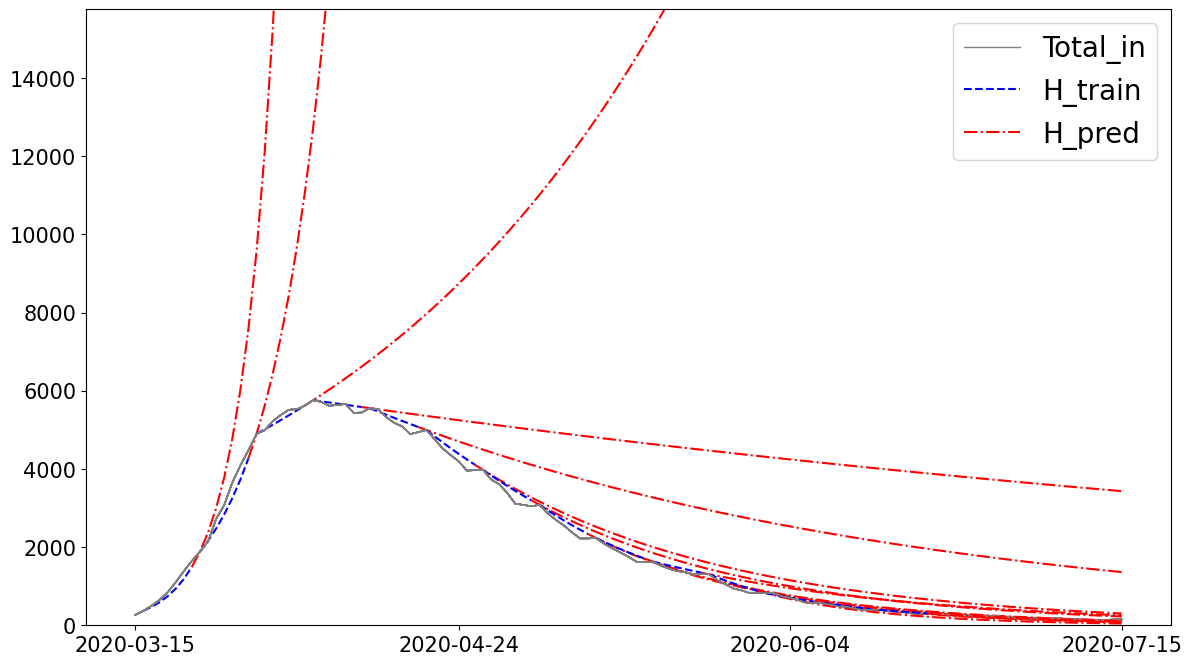

In [4]:
     
def simu(Hinit,tau,tspan):
    simu_t_start = tspan[0]
    simu_t_end = tspan[1]
    H = np.full(len(total_in), np.nan)  # set storage
    H[simu_t_start] = Hinit
    for t in np.arange(simu_t_start,simu_t_end):
        H[t] = H[simu_t_start]*math.exp(-(t-simu_t_start)/tau)  
    return H

nb_xticks = 4
dates_ticks = [None] * nb_xticks
dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
for i in range(0,nb_xticks):
    dates_ticks[i] = dates[dates_ticks_ind[i]]

fig=plt.figure(figsize=(14,8))
for cnt_period in range(0, nb_periods):
    # Extract train variables for period cnt_period:
    train_t_start = train_t_start_vals[cnt_period]
    train_t_end = train_t_end_vals[cnt_period]
    test_t_end = test_t_end_vals[cnt_period]
    tspan_train = [train_t_start,train_t_end]
    # The test data is defined to be all the data that occurs from train_t_end.
    # Replace test data by NaN in *_train variables.
    total_in_train = copy.deepcopy(total_in)  # in order to be able to "hide" entries in data_totinout_train without changing data_totinout
    total_in_train[train_t_end:] = np.nan   # Beware that data_totinout_train has to be floats.
    # ! Make sure to use only these *_train variables in the train phase.
    Hinit = total_in_train[tspan_train[0]]  
    tau=-(train_t_end-train_t_start)/(np.log(total_in[train_t_end])-np.log(total_in[train_t_start]))
    tspan=[tspan_train[0],len(total_in)]
    H=simu(Hinit,tau,tspan)
    plt.plot(dates,total_in, "-", color='gray',  linewidth=1)
    plt.plot(dates[train_t_start:train_t_end],H[train_t_start:train_t_end],'b--')
    plt.plot(dates[train_t_end-1:test_t_end],H[train_t_end-1:test_t_end],'r-.')
    #plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
plt.legend(["Total_in","H_train", "H_pred"], fontsize=20)
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,10000+np.max(total_in),100)
plt.show()
#fig.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/expo_uk.pdf')   # save the figure to file
#plt.close(fig) 

#fig.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/expo_modified.pdf')   # save the figure to file
#plt.close(fig)    # close the figure window


In [5]:
#*********************************************************
             #Optimization part and plots curves
#***************************************************
#define cost function
def phi_basic(Hinit,tau,tspan_train,total_in_train):
    train_t_start, train_t_end = tspan_train
    H=simu(Hinit,tau,tspan=tspan_train)
    cost = (np.linalg.norm(H[train_t_start:train_t_end]-total_in_train[train_t_start:train_t_end]))**2
    return cost

def make_stats(stats_all,Hinit,tau,tspan_train,dates,total_in):
        stats_keys = ['RMSE_train', 'RMSE_test', 'RRSE_train', 'RRSE_test', 'MAE_train', 'MAE_test',  'MASE', 'MASE_train', 'MASE_test',  'RelMAE_train', 'RelMAE_test', 'nMAE_train', 'nMAE_test',  'rnMAE_train', 'rnMAE_test', 'MAPE_train', 'MAPE_test',  'sMAPE_train', 'sMAPE_test']

        if not stats_all:  # If stats_all is still the empty dictionary, let's populate it.
            for key in stats_keys:
                stats_all[key] =np.full(nb_periods, np.nan) #np.full((nb_periods,),np.nan)

        H= simu(Hinit,tau, tspan=[tspan_train[0],len(total_in)])
        RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
        RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
        stats_all['RMSE_train'] = RMSE_train
        stats_all['RMSE_test'] = RMSE_test
        #stats_all['RMSE_test/RMSE_train'] = stats_all['RMSE_test'][cnt_district,cnt_period] / stats_all['RMSE_train'][cnt_district,cnt_period]
        stats_all['RRSE_train'] = np.sqrt( np.sum((total_in[train_t_start:train_t_end] - H[train_t_start:train_t_end])**2) / np.sum((total_in[train_t_start:train_t_end] - np.mean(total_in[train_t_start:train_t_end]))**2) )
        stats_all['RRSE_test'] = np.sqrt( np.sum((total_in[train_t_end:test_t_end] - H[train_t_end:test_t_end])**2) / np.sum((total_in[train_t_end:test_t_end] - np.mean(total_in[train_t_end:test_t_end]))**2) )  # Root Relative Squared Error
        #stats_all['RRSE_test/RRSE_train']= stats_all['RRSE_test'][cnt_district,cnt_period] / stats_all['RRSE_train'][cnt_district,cnt_period]
        MAE_train = np.mean(np.abs(total_in[train_t_start:train_t_end]-H[train_t_start:train_t_end]))
        MAE_test = np.mean(np.abs(total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]))
        stats_all['MAE_train'] = MAE_train
        stats_all['MAE_test'] = MAE_test
        #stats_all['MAE_test/MAE_train'] = stats_all['MAE_test'][cnt_district,cnt_period] / stats_all['MAE_train'][cnt_district,cnt_period]
        stats_all['MASE']= np.mean(np.abs(total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end])) / np.mean(np.abs(total_in[train_t_start+1:train_t_end]-total_in[train_t_start:train_t_end-1]))  # Mean Absolute Scaled Error (dubious because we make multi-step forecasts, not one-step-ahead forecasts)
        stats_all['MASE_train']= MAE_train / np.mean(np.abs(total_in[train_t_start+1:train_t_end]-total_in[train_t_start:train_t_end-1]))
        stats_all['MASE_test'] = MAE_test / np.mean(np.abs(total_in[train_t_end+1:test_t_end]-total_in[train_t_end:test_t_end-1]))  # MAE divided by MAE of the prescient naive one-step-ahead predictor (that predicts total_in[t] by total_in[t-1]). Since the decrease is slow, this can be interpreted as the MAE divided by the noise level. If it gets below 1, then the fit is visually excellent. This measure is strongly inspired from Hyndman & Koehler 2006 (https://doi.org/10.1016/j.ijforecast.2006.03.001).
        #stats_all['MASE_test/MASE_train'] = stats_all['MASE_test'][cnt_district,cnt_period] / stats_all['MASE_train'][cnt_district,cnt_period]
        stats_all['RelMAE_train'] = MAE_train / np.mean(np.abs(total_in[train_t_start:train_t_end]-total_in[train_t_start-1]))
        stats_all['RelMAE_test']= MAE_test / np.mean(np.abs(total_in[train_t_end:test_t_end]-total_in[train_t_end-1]))  # relative MAE, i.e., MAE of H divided by MAE of constant forecast total_in[train_t_end-1]
        #stats_all['RelMAE_test/RelMAE_train'] = stats_all['RelMAE_test'][cnt_district,cnt_period] / stats_all['RelMAE_train'][cnt_district,cnt_period]
        stats_all['nMAE_train'] = MAE_train / np.mean(np.abs(total_in[train_t_start:train_t_end]))
        stats_all['nMAE_test'] = MAE_test / np.mean(np.abs(total_in[train_t_end:test_t_end]))  # normalized MAE, i.e., MAE of H divided by MAE of constant forecast 0
        #stats_all['nMAE_test/nMAE_train'][cnt_period] = stats_all['nMAE_test'][cnt_district,cnt_period] / stats_all['nMAE_train'][cnt_district,cnt_period]
        stats_all['rnMAE_train'] = MAE_train / np.ptp(total_in[train_t_start:train_t_end])
        if train_t_end < test_t_end:  # if test is not empty (otherwise np.ptp below gives an error)
            stats_all['rnMAE_test'] = MAE_test / np.ptp(total_in[train_t_end:test_t_end])  # range-normalized MAE, i.e., MAE of H divided by the (diameter of the) range of the true values. (ptp means "peak to peak")
            #stats_all['rnMAE_test/rnMAE_train']= stats_all['rnMAE_test'][cnt_district,cnt_period] / stats_all['rnMAE_train'][cnt_district,cnt_period]
        else:
            stats_all['rnMAE_test'] = np.nan
            #stats_all['rnMAE_test/rnMAE_train'][cnt_period] = np.nan
        stats_all['MAPE_train'] = np.mean(np.abs( (total_in[train_t_start:train_t_end]-H[train_t_start:train_t_end]) / total_in[train_t_start:train_t_end] ))
        stats_all['MAPE_test'] = np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
        #stats_all['MAPE_test/MAPE_train'][cnt_period] = stats_all['MAPE_test'][cnt_district,cnt_period] / stats_all['MAPE_train'][cnt_district,cnt_period]
        stats_all['sMAPE_train'] = np.mean(np.abs( (total_in[train_t_start:train_t_end]-H[train_t_start:train_t_end]) / ((total_in[train_t_start:train_t_end]+H[train_t_start:train_t_end])/2) ))
        stats_all['sMAPE_test'] = np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / ((total_in[train_t_end:test_t_end]+H[train_t_end:test_t_end])/2) ))  # symmetric MAPE
        #stats_all['sMAPE_test/sMAPE_train'] = stats_all['sMAPE_test'][cnt_district,cnt_period] / stats_all['sMAPE_train'][cnt_district,cnt_period]
        return
 
# Define the loss function where "x" contains the decision variables of interest in this section of the code, namely x := [beta_bar,S_bar_init]:
def phi(x,tspan_train,total_in_train):
    return phi_basic(x[0],x[1],tspan_train,total_in_train)

# Define function for the estimation of beta_bar and S_bar_init:
def estimate_Hinit_tau(total_in_train, tspan_train):  # estimation method with beta_bar and S_bar_init as optimization variables
    fun = lambda x:phi(x, tspan_train,total_in_train)  # function phi is defined above
    x_guess=[Hinit,tau]
    x_opt = optimize.fmin(fun,x_guess)  # call the optimization solver
    Hinit_opt = x_opt[0]
    tau_opt = x_opt[1]
    fun_opt = fun([Hinit_opt,tau_opt])  # value of the minimum, useful for plot
    return (Hinit_opt,tau_opt, fun_opt, fun)


Optimization terminated successfully.
         Current function value: 8811.031796
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 93963.150146
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 27710.789461
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 18983.086442
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 20518.840463
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 19052.072949
         Iterations: 61
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 31610.532041
         Iterations: 54
         Function evaluations: 103
Opt

<ipython-input-6-91db01a6b7fe>:38: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0,10000+np.max(total_in),100)


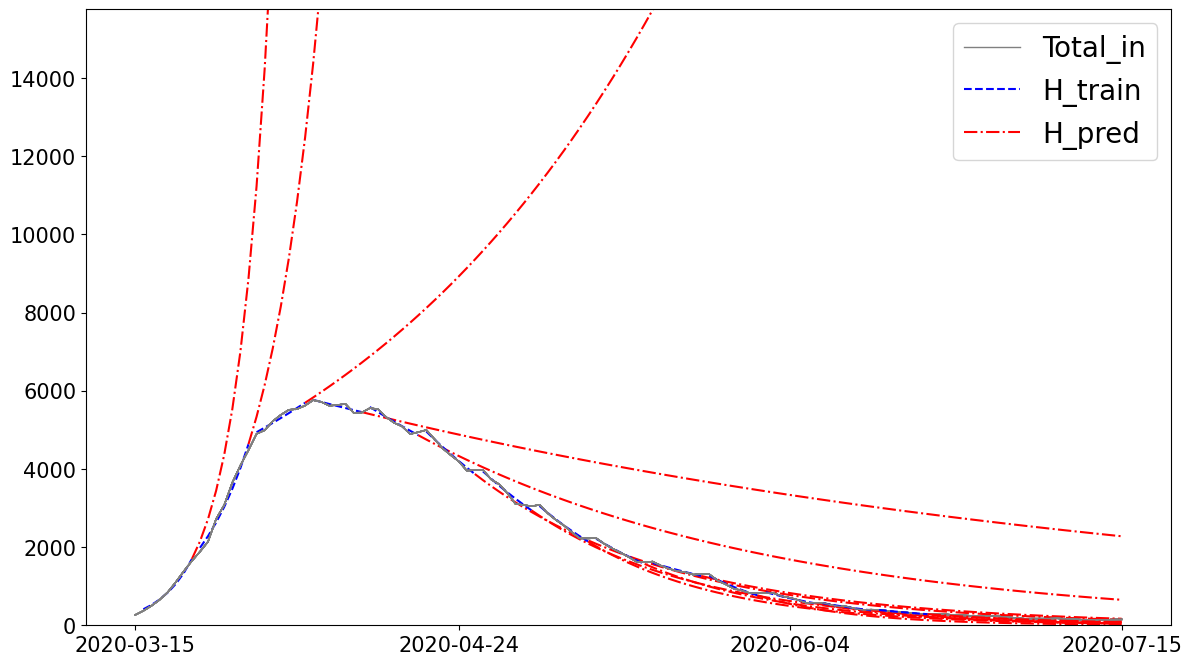

In [6]:
nb_xticks = 4
dates_ticks = [None] * nb_xticks
dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
for i in range(0,nb_xticks):
    dates_ticks[i] = dates[dates_ticks_ind[i]]
    
plt.figure(figsize=(14,8))
for cnt_period in range(0, nb_periods):
    # Extract train variables for period cnt_period:
    train_t_start = train_t_start_vals[cnt_period]
    train_t_end = train_t_end_vals[cnt_period]
    test_t_end = test_t_end_vals[cnt_period]
    tspan_train = [train_t_start,train_t_end]
    # The test data is defined to be all the data that occurs from train_t_end.
    # Replace test data by NaN in *_train variables.
    total_in_train = copy.deepcopy(total_in)  # in order to be able to "hide" entries in data_totinout_train without changing data_totinout
    total_in_train[train_t_end:] = np.nan   # Beware that data_totinout_train has to be floats.
    # ! Make sure to use only these *_train variables in the train phase.
    Hinit = total_in_train[tspan_train[0]]   
    tau=-(train_t_end-train_t_start)/(np.log(total_in[train_t_end])-np.log(total_in[train_t_start]))
    x_guess=[Hinit, tau]
    # Estimate beta_bar and S_bar_init by optimizing the cost function:
    Hinit_opt,tau_opt, fun_opt, fun= estimate_Hinit_tau(total_in_train, tspan_train)
    x_opt=[Hinit_opt,tau_opt]
    #print(x_guess, x_opt)
    tspan=[tspan_train[0],len(total_in)]
    H=simu(Hinit_opt,tau_opt,tspan)
    #MAE_test = np.mean(np.abs(total_in[t_c:len(total_in)]-H[t_c:len(total_in)]))
    #print("Train period",[t_i,t_c], "MAE_test", MAE_test)
    plt.plot(dates,total_in, "-", color='gray',  linewidth=1)
    plt.plot(dates[train_t_start:train_t_end],H[train_t_start:train_t_end],'b--')
    plt.plot(dates[train_t_end-1:test_t_end],H[train_t_end-1:test_t_end],'r-.')
    #plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.legend(["Total_in","H_train", "H_pred"], fontsize=20)
plt.xticks(dates_ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,10000+np.max(total_in),100)
plt.show()
#figg.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/expo_uk_opt.pdf')   # save the figure to file
#plt.close(figg) 



In [10]:
# Compute statistics:
stats_all = {}
for cnt_period in range(0, nb_periods):
    print("number of periods: ", nb_periods)
    # Extract train variables for period cnt_period:
    train_t_start = train_t_start_vals[cnt_period]
    train_t_end = train_t_end_vals[cnt_period]
    test_t_end = test_t_end_vals[cnt_period]
    tspan_train = [train_t_start,train_t_end]
    tspan_test = [train_t_end, test_t_end]
    # The test data is defined to be all the data that occurs from train_t_end.
    # Replace test data by NaN in *_train variables.
    total_in_train = copy.deepcopy(total_in)  # in order to be able to "hide" entries in data_totinout_train without changing data_totinout
    total_in_train[train_t_end:] = np.nan   # Beware that data_totinout_train has to be floats.
    # ! Make sure to use only these *_train variables in the train phase.
    Hinit = total_in_train[tspan_train[0]]   
    tau=-(train_t_end-train_t_start)/(np.log(total_in[train_t_end])-np.log(total_in[train_t_start]))
    x_guess=[Hinit, tau]
    # Estimate beta_bar and S_bar_init by optimizing the cost function:
    Hinit_opt,tau_opt, fun_opt, fun= estimate_Hinit_tau(total_in_train, tspan_train)
    make_stats(stats_all,Hinit_opt,tau_opt,tspan_train,dates,total_in)
    print("period train: ", tspan_train, "period test: ", tspan_test)
    print("MAPE_test with Hinit and tau optimized (for last experiment, if several): ",stats_all['MAPE_test'])
    print("")

number of periods:  14
Optimization terminated successfully.
         Current function value: 8811.031796
         Iterations: 47
         Function evaluations: 88
period train:  [1, 8] period test:  [8, 123]
MAPE_test with Hinit and tau optimized (for last experiment, if several):  301757595146.7184

number of periods:  14
Optimization terminated successfully.
         Current function value: 93963.150146
         Iterations: 47
         Function evaluations: 91
period train:  [8, 15] period test:  [15, 123]
MAPE_test with Hinit and tau optimized (for last experiment, if several):  8915917.661301265

number of periods:  14
Optimization terminated successfully.
         Current function value: 27710.789461
         Iterations: 48
         Function evaluations: 93
period train:  [15, 22] period test:  [22, 123]
MAPE_test with Hinit and tau optimized (for last experiment, if several):  80.50282207302621

number of periods:  14
Optimization terminated successfully.
         Current functi